In [17]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import zipfile
import pandas as pd
from tqdm.auto import tqdm
from io import TextIOWrapper
from collections import defaultdict

In [18]:
def get_records(path, measure):

    trial_indices = defaultdict(int)
    
    with zipfile.ZipFile(path, 'r') as z:
        for filename in tqdm(z.namelist()):
            if filename.endswith('.json'):
                with z.open(filename) as file:
                    with TextIOWrapper(file, encoding='utf-8') as text_file:
                        try:
                            result = json.load(text_file)
                            record = pd.DataFrame(
                                result['annotations']
                            ).reindex(
                                columns=['ABL1 pIC50', 'Log P', 'Log S']
                            ).dropna()

                            value = result[measure]
                            trial_indices[value] += 1
                            record[measure] = value
                            record['trial'] = trial_indices[value]
                            
                            records.append(record)
                            result = None
                        except:
                            continue
    return records

paths = [
    '../../dgym-data/analysis/noise/selection_noise_2024-05-06_09-23-46.zip',
]

measure = 'sigma'
records = []
for path in paths:
    records.extend(get_records(path, measure))

df_raw = pd.concat(records)
records = None

  0%|          | 0/1088 [00:00<?, ?it/s]

In [19]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction([
    docking_utility_function, log_P_utility_function, log_S_utility_function])

In [20]:
records = []
for (value, trial), data in tqdm(df_raw.groupby([measure, 'trial'])):
    utility = composite_utility_function(data.values, precompute=True, method='average')
    try:
        cost = utility.index(1.0)
        success = 1
    except:
        cost = len(utility)
        success = 0

    record = {measure: value, 'trial': trial, 'outcome': success, 'cost': cost}
    records.append(record)

df = pd.DataFrame(records)

  0%|          | 0/1086 [00:00<?, ?it/s]

Plotting adjusted outcomes.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Determine the maximum cost to extend the eCDF
max_cost = df['cost'].max()
timeline = np.linspace(0, max_cost, 500)

ecdfs = []
for idx, (value, group) \
    in enumerate(df.groupby(measure)):
    
    # Create Kaplan-Meier object
    kmf = KaplanMeierFitter()

    # Fit data
    kmf.fit(
        durations=group['cost'],
        event_observed=group['outcome'],
        timeline=timeline,
        alpha=0.32
    )
    
    # add confidence intervals
    ecdf_ = pd.merge(
        kmf.cumulative_density_,
        right=kmf.confidence_interval_cumulative_density_,
        left_index=True,
        right_index=True
    ).reset_index()
    
    ecdf_[measure] = value
    ecdfs.append(ecdf_)

ecdf = pd.concat(ecdfs)

<>:27: DeprecationWarning: invalid escape sequence '\s'
<>:32: DeprecationWarning: invalid escape sequence '\s'
<>:27: DeprecationWarning: invalid escape sequence '\s'
<>:32: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_45665/1659166153.py:27: DeprecationWarning: invalid escape sequence '\s'
  plt.legend(title='$\sigma$')
/tmp/ipykernel_45665/1659166153.py:32: DeprecationWarning: invalid escape sequence '\s'
  plt.title('Cumulative probability of success versus model error ($\sigma$)')
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype,

Text(0.5, 1.0, 'Cumulative probability of success versus model error ($\\sigma$)')

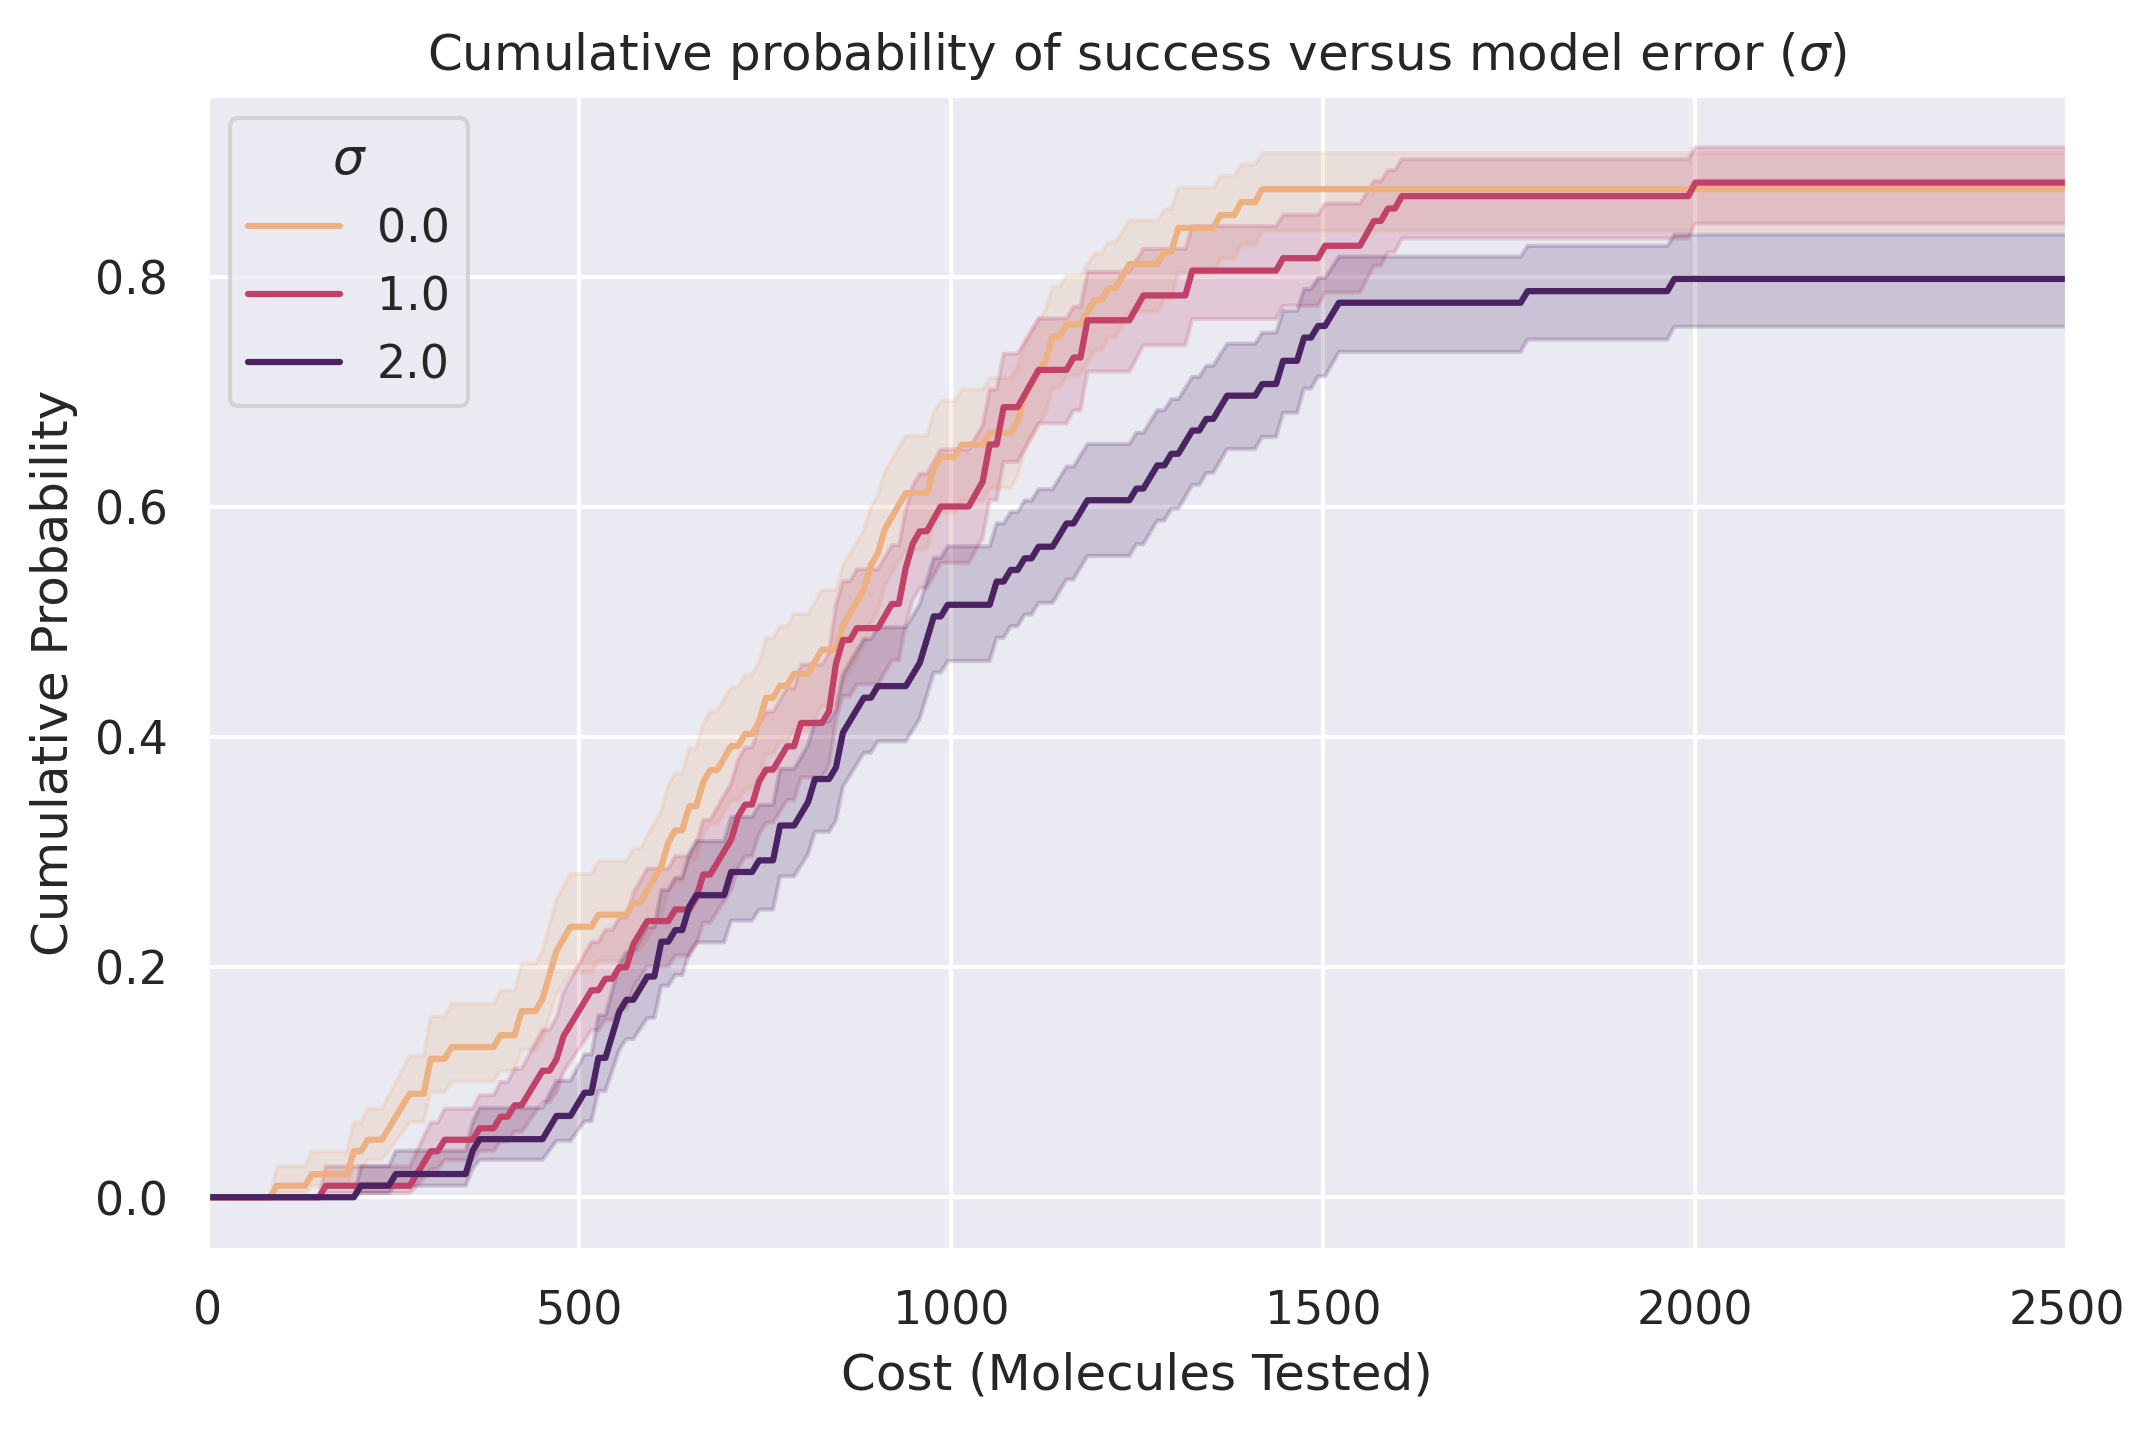

In [30]:
import seaborn as sns

plt.figure(figsize=(8, 5), dpi=300)

interval = 1
sns.set()
g = sns.lineplot(
    ecdf.query(f'{measure} % {interval} == 0'),
    x='timeline',
    y='KM_estimate',
    hue=measure,
    palette='flare'
)

colormap = sns.palettes.get_colormap('flare')
colors = colormap.resampled(len(ecdf.query(f'{measure} % {interval} == 0').groupby(measure)))

for idx, (name, group) in enumerate(ecdf.query(f'{measure} % {interval} == 0').groupby(measure)):
    g.fill_between(
        group['timeline'],
        group['KM_estimate_lower_0.68'],
        group['KM_estimate_upper_0.68'],
        alpha=0.2,
        color=colors.colors[idx]
    )

plt.legend(title='$\sigma$')
plt.xlabel('Cost (Molecules Tested)')
plt.ylabel('Cumulative Probability')
plt.xlim(-0.05, 2500)
# plt.ylim(-0.05, 1.05)
plt.title('Cumulative probability of success versus model error ($\sigma$)')

### Plot variable vs. outcome

<>:15: DeprecationWarning: invalid escape sequence '\s'
<>:15: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_45665/3129316136.py:15: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel('Model error ($\sigma$)')
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Success rate versus model error | Budget = 600 molecules')

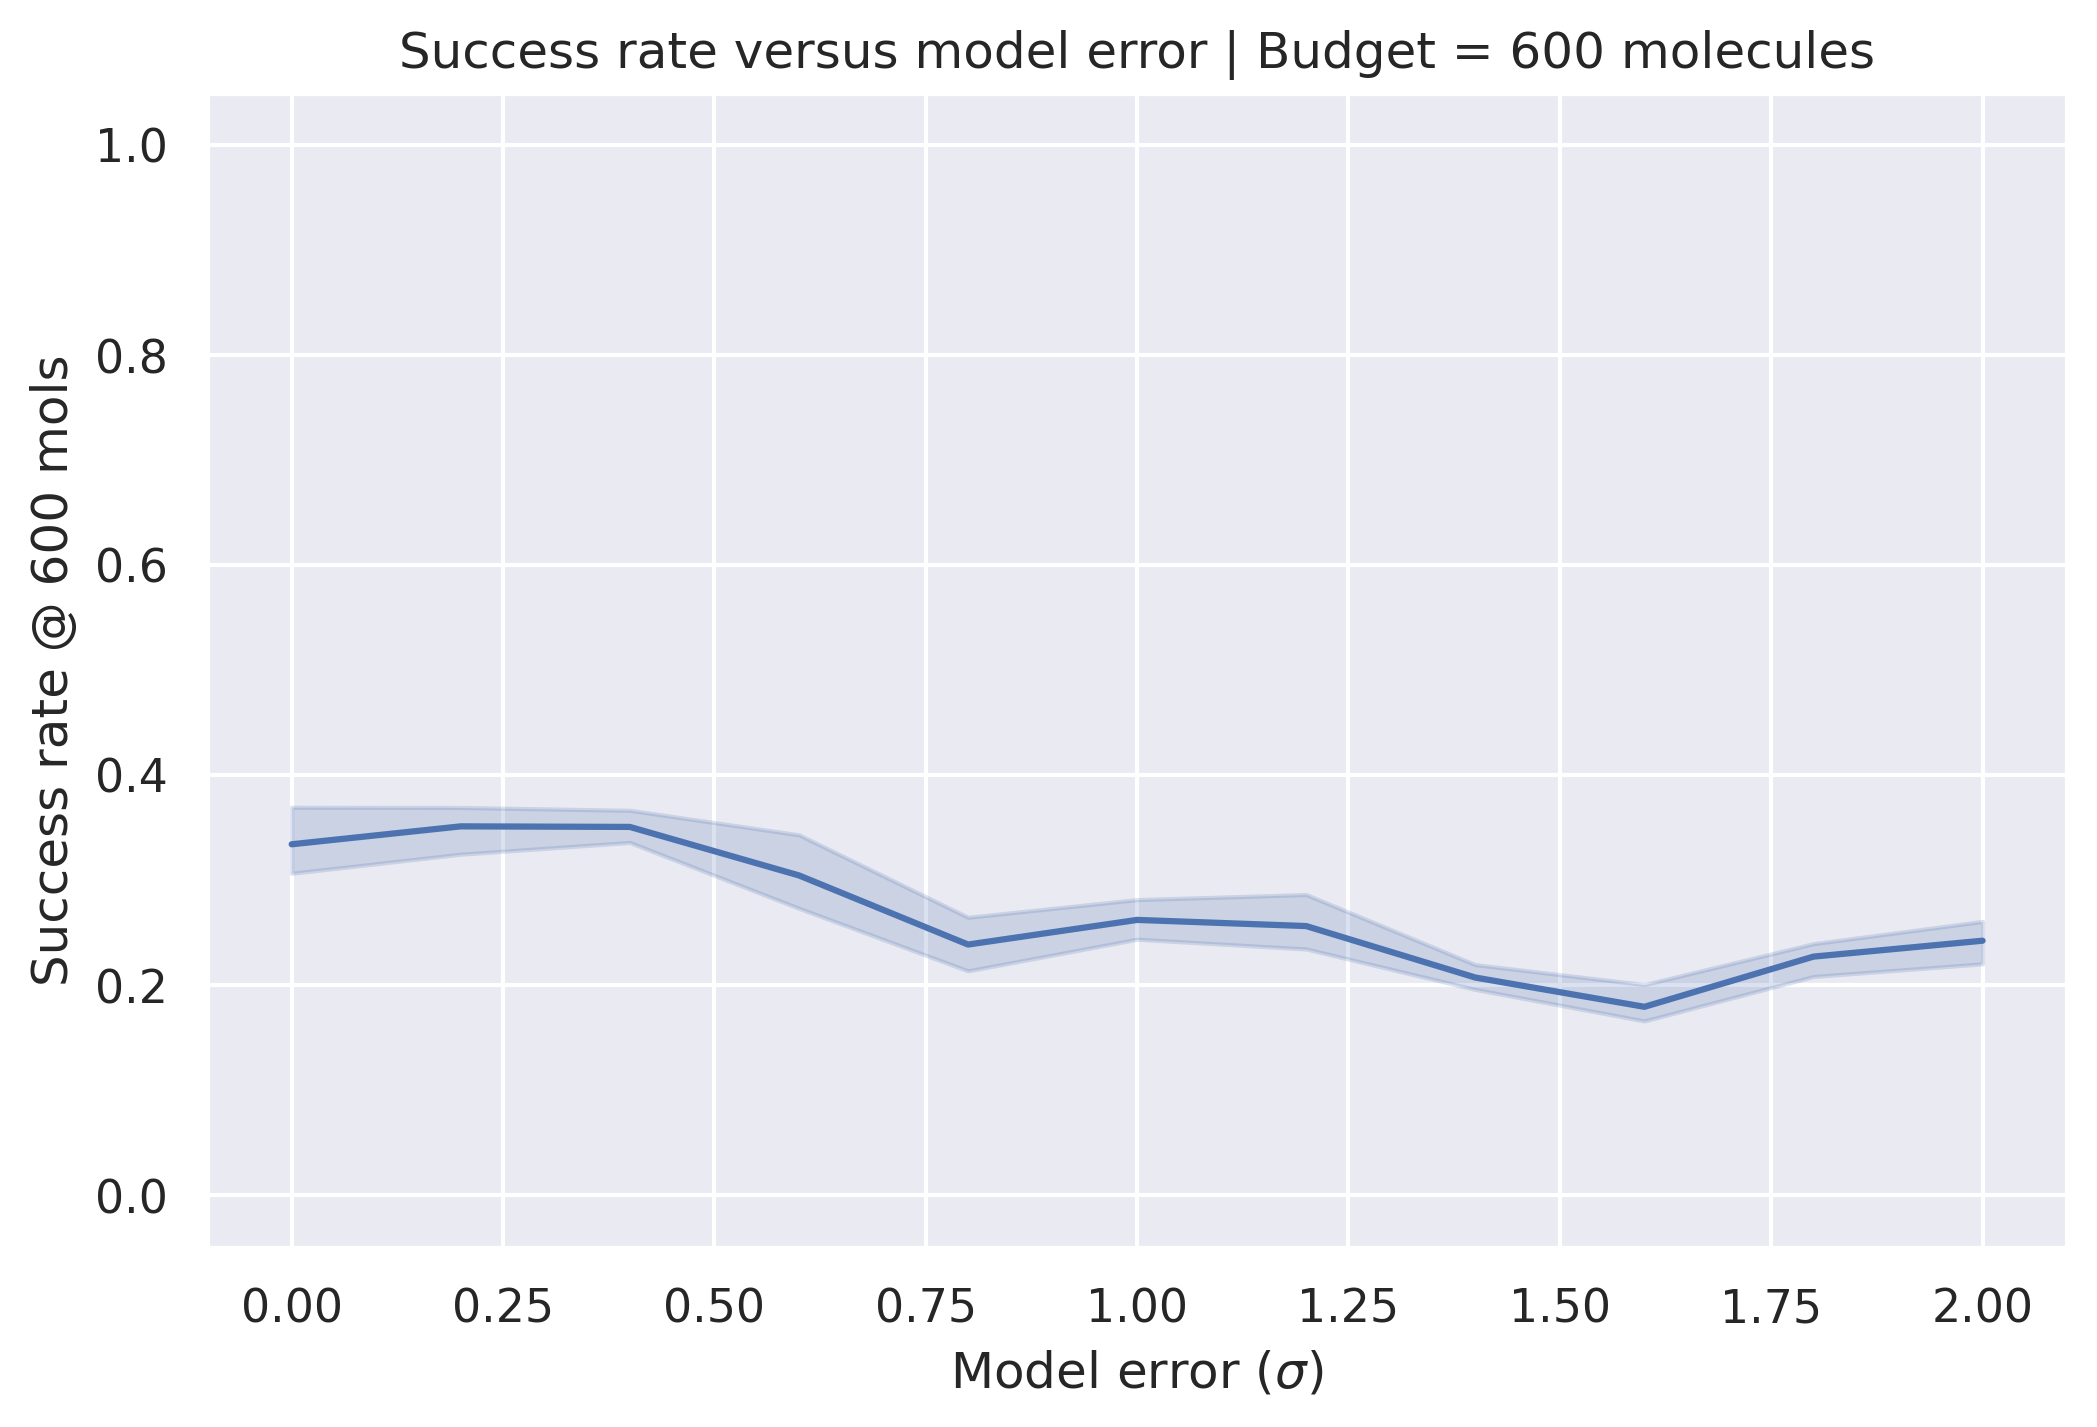

In [54]:
plt.figure(figsize=(8, 5), dpi=300)

budget = 600
filtered = ecdf.query(
    f'{budget} < timeline < {budget} + 100')

g = sns.lineplot(
    filtered,
    x='sigma',
    y='KM_estimate',
    errorbar=('ci', 100)
)

plt.ylim(-0.05, 1.05)
plt.xlabel('Model error ($\sigma$)')
plt.ylabel(f'Success rate @ {budget} mols')
plt.title(f'Success rate versus model error | Budget = {budget} molecules')

## Expected costs to achieve probability of success

In [188]:
df_copy = df.query('temperature_index < 7').copy()
failed = df_copy.query('outcome == 0').index
df_copy.loc[failed, 'cost'] = np.inf

bootstraps = []
percentile = 0.75
for value, df_value in tqdm(df_copy.groupby(measure)):
    percentile_threshold = int(percentile * len(df_value))
    
    for _ in range(1000):
        # Bootstrap samples
        df_value_sampled = df_value.sample(len(df_value), replace=True)
        
        # Sort and cumulative sum outcomes
        df_value_sorted = df_value_sampled.sort_values('cost')
        cumulative_sum = df_value_sorted['outcome'].cumsum()
        percentile_index = np.where(cumulative_sum == percentile_threshold)
        
        # Find cost and add to records
        try:
            percentile_cost = df_value_sorted.iloc[percentile_index]['cost'].values[0]
            bootstraps.append({measure: value, 'cost': percentile_cost})
        except:
            bootstraps.append({measure: value, 'cost': np.nan})
            
bootstraps = pd.DataFrame(bootstraps)
bootstraps = temperature_map(bootstraps)

measure_local = 'temperature'
ci_records = []
for value in pd.unique(bootstraps[measure_local]):
    lower_ci = bootstraps.query(f'{measure_local} == {value}').sort_values('cost').iloc[50]['cost']
    upper_ci = bootstraps.query(f'{measure_local} == {value}').sort_values('cost').iloc[1000-50]['cost']
    ci_records.append({measure_local: value, 'lower': lower_ci, 'upper': upper_ci})

intervals = pd.DataFrame(ci_records)
intervals = intervals.fillna(bootstraps['cost'].max())

  0%|          | 0/7 [00:00<?, ?it/s]

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Expected cost versus Temperature | $P_{success}$ > 75%')

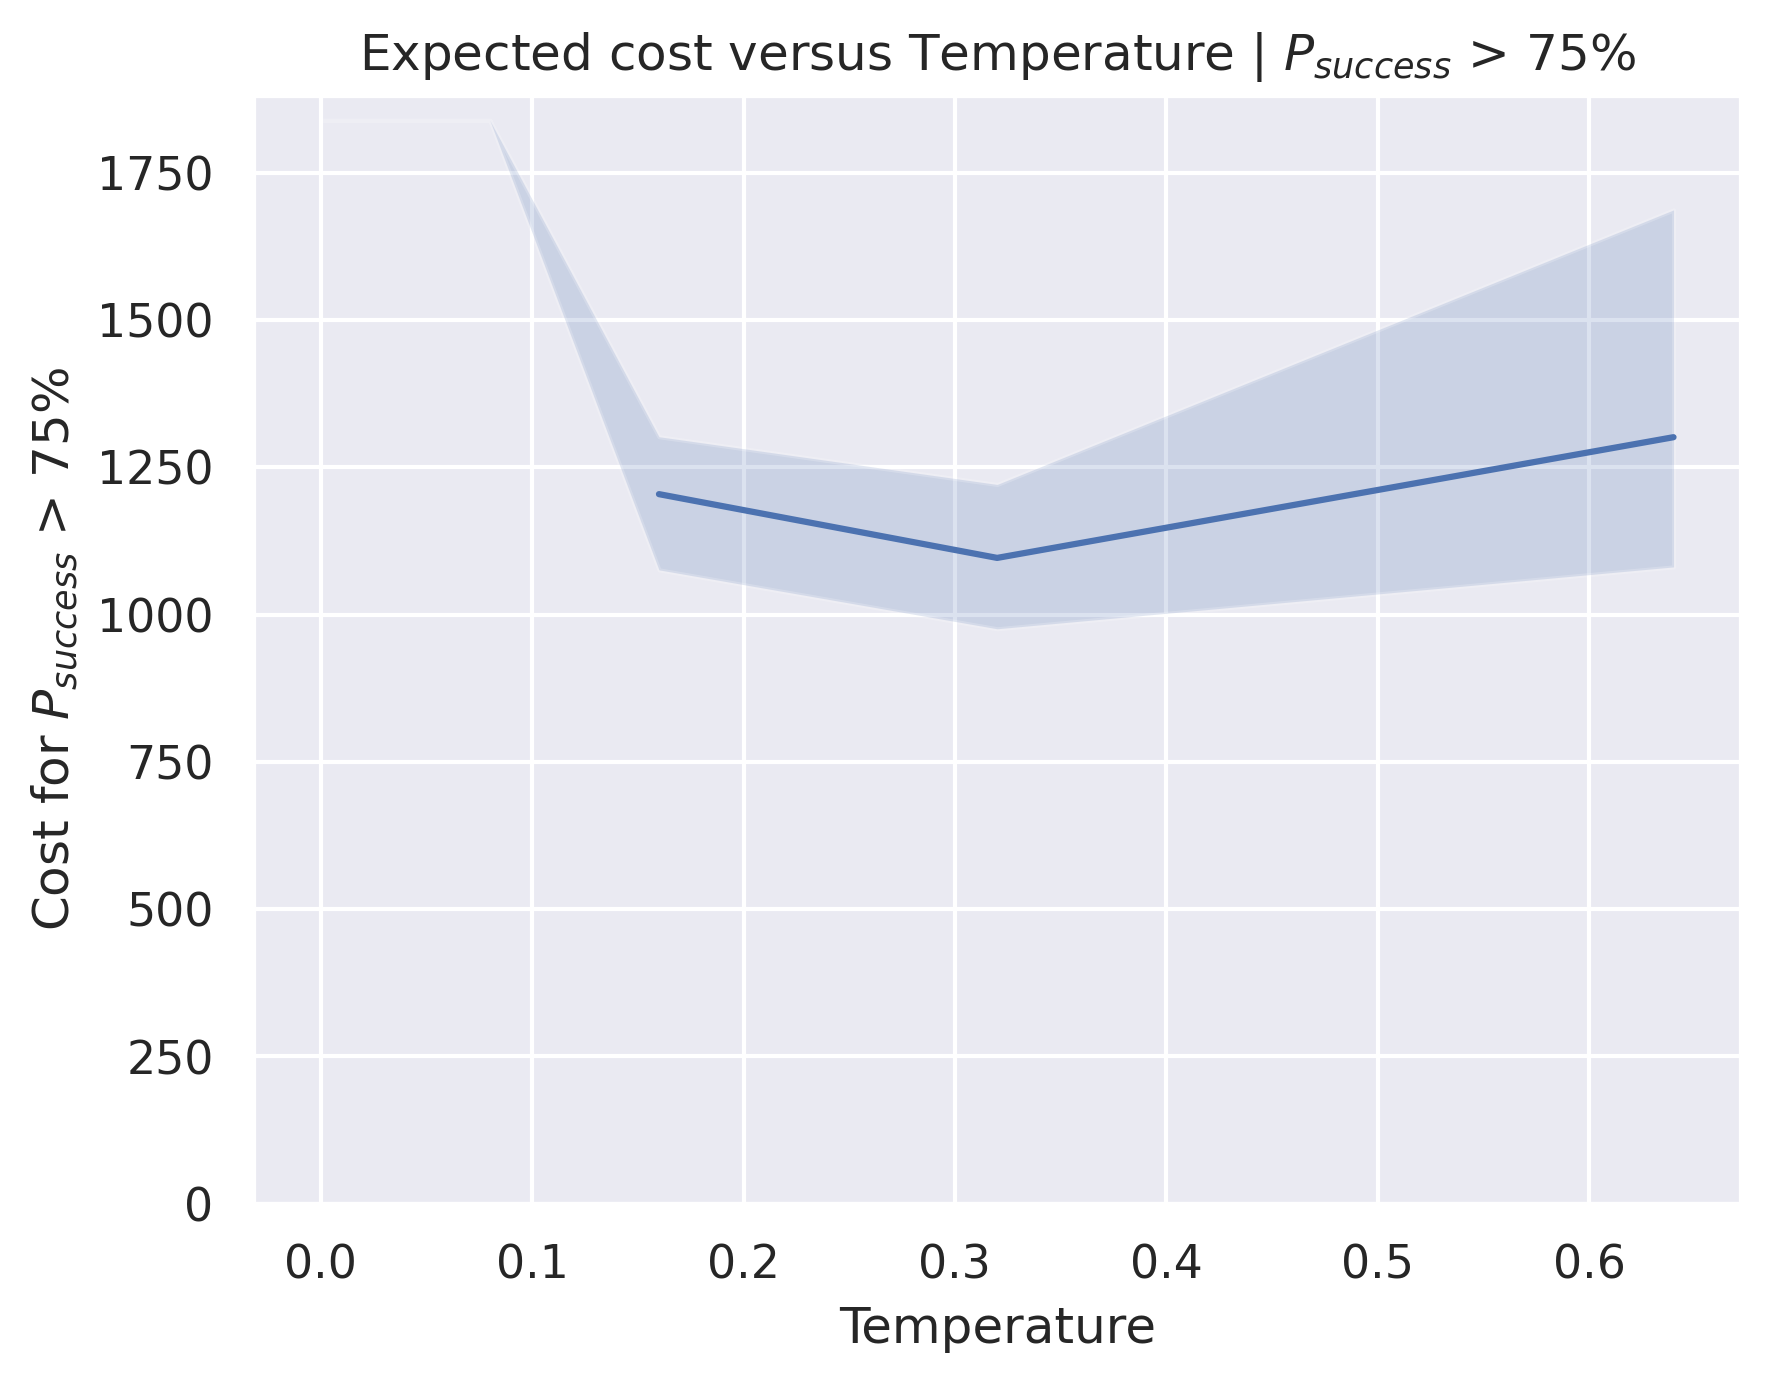

In [189]:
figure = plt.figure(dpi=300)
g = sns.lineplot(
    bootstraps,
    x='temperature', y='cost', ci=None
)

g.fill_between(
    intervals['temperature'],
    intervals['lower'],
    intervals['upper'],
    alpha=0.2,
)

plt.ylim(0)
# plt.xlim(-0.05, 2.05)
plt.xlabel('Temperature')
p_success = '$P_{success}$'
plt.ylabel(f'Cost for {p_success} > {int(percentile * 100)}%')
plt.title(f'Expected cost versus Temperature | {p_success} > {int(percentile * 100)}%')

## Expectations

<>:28: DeprecationWarning: invalid escape sequence '\s'
<>:28: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_45665/1240342386.py:28: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel('Model error ($\sigma$)')
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Expected cost versus model error | Probability of Success = 80.0%')

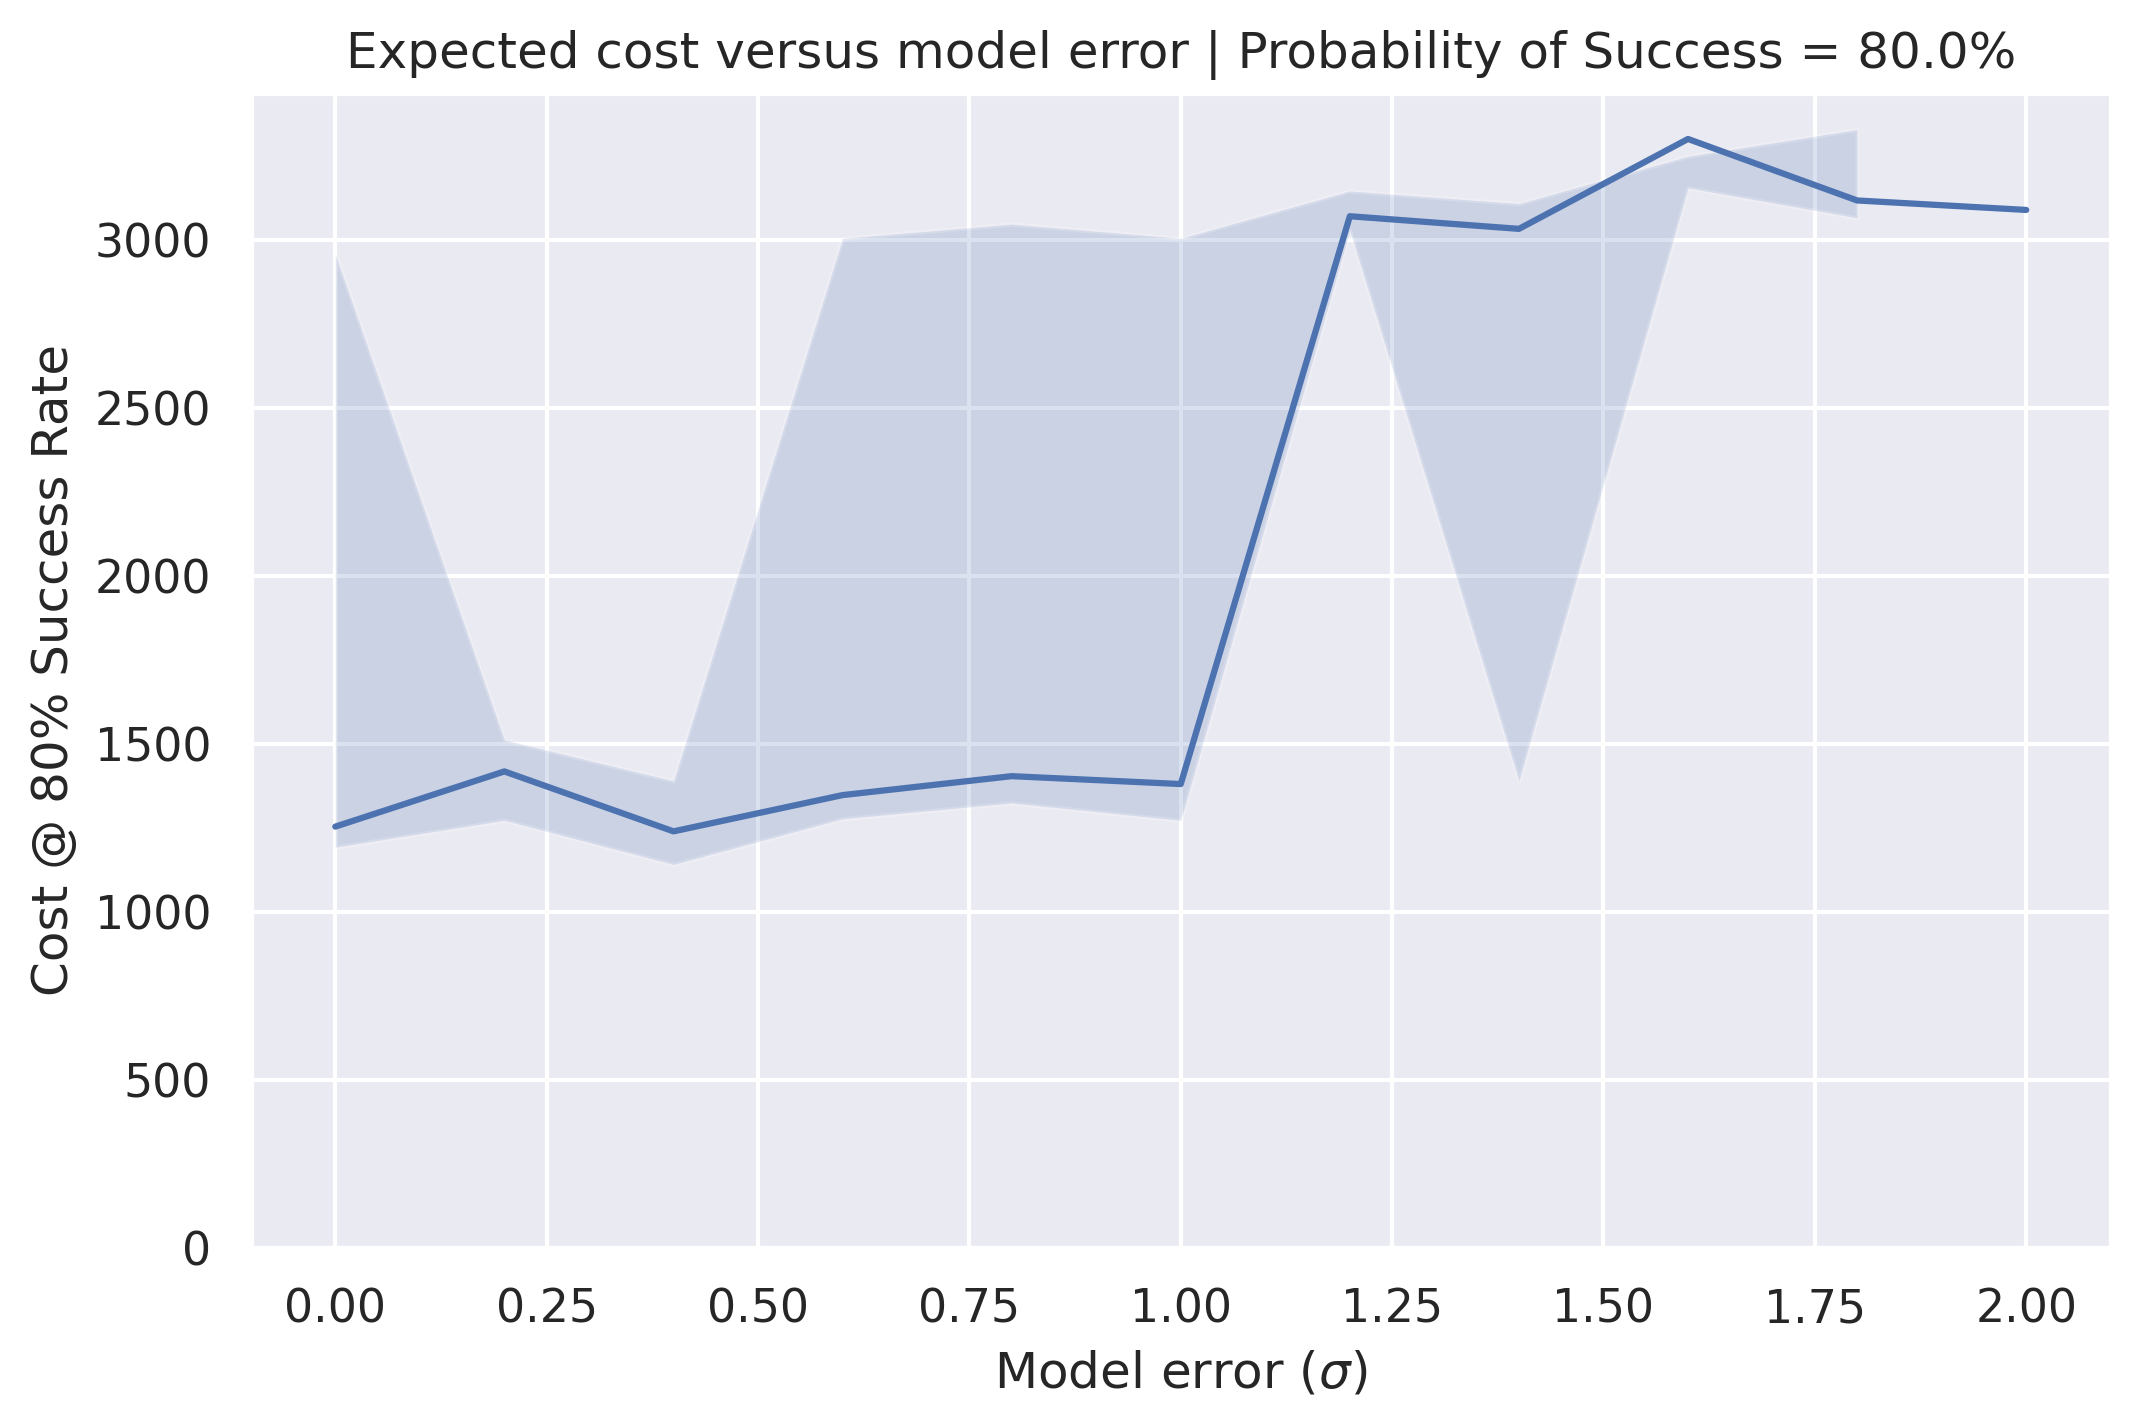

In [69]:
plt.figure(figsize=(8, 5), dpi=300)

prob_success = 0.8
filtered = ecdf.query(f'{prob_success} - 0.05 < KM_estimate < {prob_success} + 0.05')
filtered_low = ecdf.query(f'{prob_success} - 0.05 < `KM_estimate_lower_0.68` < {prob_success} + 0.05')
filtered_high = ecdf.query(f'{prob_success} - 0.05 < `KM_estimate_upper_0.68` < {prob_success} + 0.05')

filtered_mean = filtered.groupby('sigma').agg({'timeline': 'mean'})
filtered_low = filtered_low.groupby('sigma').agg({'timeline': 'mean'})
filtered_high = filtered_high.groupby('sigma').agg({'timeline': 'mean'})
filtered_mean['# reactants changed'] = 1

g = sns.lineplot(
    filtered_mean,
    x='sigma',
    y='timeline',
)

max_ci_length = min(len(filtered_mean), len(filtered_low), len(filtered_high))
g.fill_between(
    filtered_mean.index[:max_ci_length],
    filtered_low['timeline'].iloc[:max_ci_length],
    filtered_high['timeline'].iloc[:max_ci_length],
    alpha=0.2,
)

plt.ylim(0)
plt.xlabel('Model error ($\sigma$)')
plt.ylabel(f'Cost @ {round(prob_success * 100)}% Success Rate')
plt.title(f'Expected cost versus model error | Probability of Success = {prob_success * 100}%')